# Complex NetCDF to Zarr Recipe: TerraClimate 

## About the Dataset

From http://www.climatologylab.org/terraclimate.html:

> TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019. We plan to update these data periodically (annually).

## What makes it tricky

This is an advanced example that illustrates the following concepts
- _Multiple variables in different files_: There is one file per year for a dozen different variables.
- _Complex Preprocessing_: We want to apply different preprocessing depending on the variable. This example shows how.
- _Inconsistent size of data in input files_: This means we have to scan each input file and cache its metadata before we can start writing the target.

This recipe requires a new storage target, a `metadata_cache`. In this example, this is just another directory. You could hypothetically use a database or other key/value store for this.

In [1]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
import xarray as xr

## Define Filename Pattern 

To keep this example smaller, we just use two years instead of the whole record.

In [2]:
target_chunks = {"lat": 1024, "lon": 1024, "time": 12}
# only do two years to keep the example small; it's still big!
years = list(range(1958, 1960))
variables = [
    "aet",
    "def",
    "pet",
    "ppt",
    "q",
    "soil",
    "srad",
    "swe",
    "tmax",
    "tmin",
    "vap",
    "ws",
    "vpd",
    "PDSI",
]

def make_filename(variable, time):
    return f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{variable}_{time}.nc"

pattern = FilePattern(
    make_filename,
    ConcatDim(name="time", keys=years),
    MergeDim(name="variable", keys=variables)
)
pattern

<FilePattern {'time': 2, 'variable': 14}>

Check out the pattern:

In [3]:
for key, filename in pattern.items():
    break
key, filename

((DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>),
  DimIndex(name='variable', index=0, sequence_len=14, operation=<CombineOp.MERGE: 1>)),
 'http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_aet_1958.nc')

## Define Preprocessing Functions

These functions apply masks for each variable to remove invalid data.

In [4]:
rename_vars = {'PDSI': 'pdsi'}

mask_opts = {
    "PDSI": ("lt", 10),
    "aet": ("lt", 32767),
    "def": ("lt", 32767),
    "pet": ("lt", 32767),
    "ppt": ("lt", 32767),
    "ppt_station_influence": None,
    "q": ("lt", 2147483647),
    "soil": ("lt", 32767),
    "srad": ("lt", 32767),
    "swe": ("lt", 10000),
    "tmax": ("lt", 200),
    "tmax_station_influence": None,
    "tmin": ("lt", 200),
    "tmin_station_influence": None,
    "vap": ("lt", 300),
    "vap_station_influence": None,
    "vpd": ("lt", 300),
    "ws": ("lt", 200),
}

def apply_mask(key, da):
    """helper function to mask DataArrays based on a threshold value"""
    if mask_opts.get(key, None):
        op, val = mask_opts[key]
        if op == "lt":
            da = da.where(da < val)
        elif op == "neq":
            da = da.where(da != val)
    return da


def preproc(ds):
    """custom preprocessing function for terraclimate data"""
    
    rename = {}

    station_influence = ds.get("station_influence", None)

    if station_influence is not None:
        ds = ds.drop_vars("station_influence")

    var = list(ds.data_vars)[0]

    if var in rename_vars:
        rename[var] = rename_vars[var]

    if "day" in ds.coords:
        rename["day"] = "time"

    if station_influence is not None:
        ds[f"{var}_station_influence"] = station_influence

    with xr.set_options(keep_attrs=True):
        ds[var] = apply_mask(var, ds[var])

    if rename:
        ds = ds.rename(rename)
                
    return ds


## Define Recipe

We are now ready to define the recipe.
We also specify the desired chunks of the target dataset.

A key property of this recipe is `nitems_per_input=None`, which triggers caching of input metadata.

In [5]:
chunks = {"lat": 1024, "lon": 1024, "time": 12}

recipe = XarrayZarrRecipe(
    file_pattern=pattern,
    target_chunks=target_chunks,
    process_chunk=preproc
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2, 'variable': 14}>, inputs_per_chunk=1, target_chunks={'lat': 1024, 'lon': 1024, 'time': 12}, target=None, input_cache=None, metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=<function preproc at 0x181d72670>, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

## Define Storage Targets

Since we did not specify `nitems_per_file` in our `ConcatDim`, the recipe needs to cache input metadata.
So we need to suply a `metadata_cache` target.

In [6]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget, MetadataTarget

fs_local = LocalFileSystem()

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

meta_dir = tempfile.TemporaryDirectory()
meta_store = MetadataTarget(fs_local, meta_dir.name)

recipe.target = target
recipe.input_cache = cache_target
recipe.metadata_cache = meta_store
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2, 'variable': 14}>, inputs_per_chunk=1, target_chunks={'lat': 1024, 'lon': 1024, 'time': 12}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cf2f070>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmp6x6lolkd'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cf2f070>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpb624tnet'), metadata_cache=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cf2f070>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmp51ibke15'), cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=<function preproc at 0x181d72670>, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=

## Execute with Prefect

This produces A LOT of output because we turn on logging.

In [7]:
# logging will display some interesting information about our recipe during execution
import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger("pangeo_forge_recipes")
logger.setLevel(logging.INFO)

In [ ]:
flow = recipe.to_prefect()
flow.run()

[2021-11-13 22:49:36-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'pangeo-forge-recipe'
2021-11-13 22:49:36 [INFO] prefect.FlowRunner - Beginning Flow run for 'pangeo-forge-recipe'
[2021-11-13 22:49:36-0500] INFO - prefect.TaskRunner | Task 'cache_input': Starting task run...
2021-11-13 22:49:36 [INFO] prefect.TaskRunner - Task 'cache_input': Starting task run...
[2021-11-13 22:49:36-0500] INFO - prefect.TaskRunner | Task 'cache_input': Finished task run for task with final state: 'Mapped'
2021-11-13 22:49:36 [INFO] prefect.TaskRunner - Task 'cache_input': Finished task run for task with final state: 'Mapped'
[2021-11-13 22:49:36-0500] INFO - prefect.TaskRunner | Task 'cache_input[0]': Starting task run...
2021-11-13 22:49:36 [INFO] prefect.TaskRunner - Task 'cache_input[0]': Starting task run...
2021-11-13 22:49:36 [INFO] pangeo_forge_recipes.recipes.xarray_zarr - Caching input 'time-0,variable-0'
2021-11-13 22:49:36 [INFO] pangeo_forge_recipes.storage - Caching file 'http

## Check and Plot Target

In [10]:
ds_target = xr.open_zarr(target.get_mapper(), consolidated=True)
ds_target

<xarray.Dataset>
Dimensions:  (crs: 1, lat: 4320, lon: 8640, time: 24)
Coordinates:
  * crs      (crs) int16 3
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 1959-12-01
Data variables: (12/14)
    aet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    def      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pdsi     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pet      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt      (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    q        (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ...       ...
    swe      (time, lat, lon) float64 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmax     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmin     (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vap      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vpd      (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ws       (time, lat, lon) float32 dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6
    acknowledgment:                  Please cite the references included here...
    cdm_data_type:                   GRID
    contributor_email:               khegewisch@ucmerced.edu
    contributor_name:                Katherine Hegewisch
    contributor_role:                Postdoctoral Fellow
    ...                              ...
    time_coverage_duration:          P1Y
    time_coverage_end:               1958-12-01T00:0
    time_coverage_resolution:        P1M
    time_coverage_start:             1958-01-01T00:0
    title:                           TerraClimate: monthly climate and climat...
    version:                         v1.0

As an example calculation, we compute and plot the seasonal climatology of soil moisture.

In [11]:
with xr.set_options(keep_attrs=True):
    soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()
soil_clim

<xarray.DataArray 'soil' (season: 4, lat: 360, lon: 720)>
dask.array<mean_agg-aggregate, shape=(4, 360, 720), dtype=float32, chunksize=(1, 86, 86), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Soil Moisture at End of Month
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          soil_moisture_content
    standard_name:      soil_moisture_content
    units:              mm

/opt/miniconda3/envs/pangeo-forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


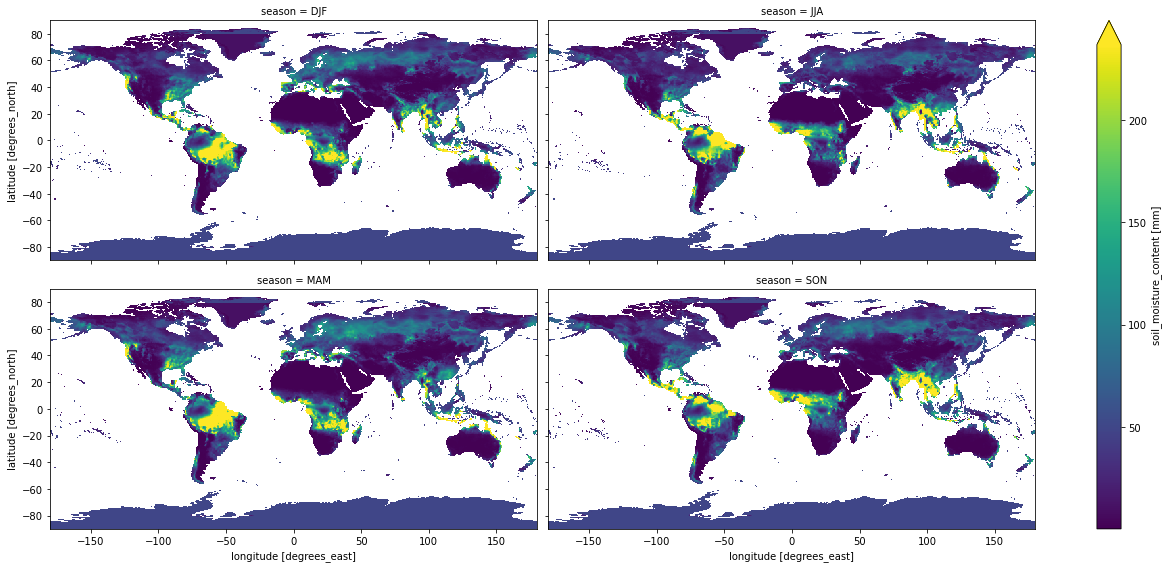

In [12]:
soil_clim.plot(col='season', col_wrap=2, robust=True, figsize=(18, 8))